# Deformation maps and ACF

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image
import numpy as np
import scipy.ndimage
from matplotlib import gridspec
from skimage.transform import radon, rescale, resize,frt2
from skimage.morphology import skeletonize
from skimage import io, color, measure
from scipy.signal import medfilt, find_peaks_cwt
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
%matplotlib inline

# ACF from displacement along x and y

In [2]:
class DeformationMap():
    
    def __init__(self,path,fname) :
        self.path=path
        self.fname=fname
        self.data=np.loadtxt(self.path+self.fname,skiprows=1)
        self.xc=self.data[:,0] #x coordinates
        self.yc=self.data[:,1] #y coordinates
        self.xd=self.data[:,2] #x displacement
        self.yd=self.data[:,3] #y displacement
        
        self.xdim=(self.xc.max()-self.xc.min()
                  )/min(abs((np.diff(self.xc))))+1 #size of map along x
        self.ydim=(self.yc.max()-self.yc.min()
                  )/max(abs((np.diff(self.yc))))+1 #size of map along y
        self.x_map=self._map(self.xd,self.ydim,self.xdim) #u (displacement component along x) 
        self.y_map=self._map(self.yd,self.ydim,self.xdim) #v (displacement component along y) 
        self.f11=self._grad(self.x_map)[1]*100#f11
        self.f22=self._grad(self.y_map)[0]*100#f22
        self.f12=self._grad(self.x_map)[0]*100#f12
        self.f21=self._grad(self.y_map)[1]*100#f21
        
        self.max_shear=np.sqrt((((self.f11-self.f22)/2.)**2)
                               + ((self.f12+self.f21)/2.)**2)# max shear component
        self.mapshape=np.shape(self.max_shear)
        
    def _map(self,data_col,ydim,xdim):
        data_map=np.reshape(np.array(data_col),(int(ydim),int(xdim)))
        return data_map
    
    def _grad(self,data_map) :
        grad_step=min(abs((np.diff(self.xc))))
        data_grad=np.gradient(data_map,grad_step,grad_step)
        return data_grad

In [3]:
def_map=DeformationMap('','data_for_ACF.txt')

0.04806975798716745


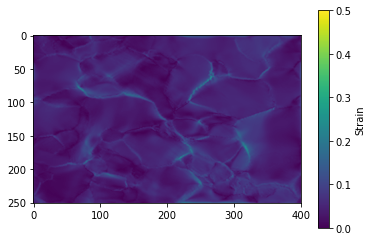

In [4]:
plt.imshow(def_map.max_shear,cmap='viridis',vmin=0, vmax=0.5);
print(np.mean(def_map.max_shear))
plt.colorbar(label='Strain')
matplotlib.image.imsave('strainmap.png', def_map.max_shear)

In [5]:
def acorr_map(def_map,c_range=[]):
    acorr=(np.fft.fft2(def_map)*np.conjugate(np.fft.fft2(def_map)))
    ashift=np.fft.fftshift(acorr)
    corr_map=np.log(np.fft.fftshift((np.abs(np.fft.ifft2(ashift)))))
    if c_range==[]:
        plt.imshow(corr_map, interpolation='nearest', cmap='viridis');
    else:
        plt.imshow(corr_map, interpolation='nearest', cmap='viridis',
                   vmin=c_range[0], vmax=c_range[1]);
    return corr_map

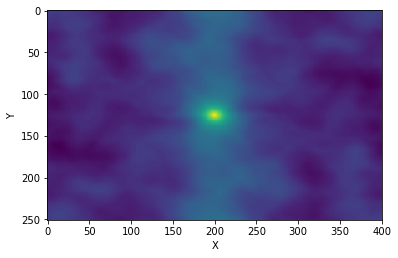

In [7]:
x=acorr_map(def_map.max_shear)
plt.xlabel('X')
plt.ylabel('Y')
matplotlib.image.imsave('ACF.png', x)